## Neural network predicting 5 points at once

In [1]:
# Necessary in colab:
#! git clone https://github.com/crowdbotp/OpenTraj.git
#! pip install pykalman

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj/') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
# tensorflow logging level
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Data preparation

In [3]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=4)

reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████| 2342/2342 [01:02<00:00, 37.54it/s]


Warning! too big dt in [Edinburgh]
finish


In [4]:
data = traj_dataset.data
NUM_OF_STEPS = 5

# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

In [5]:
# 'Normalize' the data so that all trajectories will begin at x=0, y=0
for agent_id in agent_ids:
    first_x = data[data.agent_id == agent_id]['pos_x'].iloc[0]
    first_y = data[data.agent_id == agent_id]['pos_y'].iloc[0]
    
    data.loc[data.agent_id == agent_id, 'pos_x'] = data[data.agent_id == agent_id]['pos_x'] - first_x
    data.loc[data.agent_id == agent_id, 'pos_y'] = data[data.agent_id == agent_id]['pos_y'] - first_y

In [6]:
# Select the useful columns from the dataset
data = data[['index', 'agent_id', 'pos_x', 'pos_y']]

In [7]:
from sklearn.model_selection import train_test_split
train_agent_ids, test_agent_ids = train_test_split(agent_ids, test_size=0.2)

### Helper functions

In [8]:
def create_dataset(data, agent_ids):
    data_X, data_Y_pos_x, data_Y_pos_y = [], [], []
    for agent_id in agent_ids:
        x = data[data['agent_id'] == agent_id].iloc[:5][['pos_x', 'pos_y']]
        y_pos_x = data[data['agent_id'] == agent_id].iloc[5:10]['pos_x']
        y_pos_y = data[data['agent_id'] == agent_id].iloc[5:10]['pos_y']
        data_X.append(x)
        data_Y_pos_x.append(y_pos_x)
        data_Y_pos_y.append(y_pos_y)
    return np.array(data_X), np.array(data_Y_pos_x), np.array(data_Y_pos_y)
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

## Experiment

In [9]:
train = create_dataset(data, train_agent_ids)
test = create_dataset(data, test_agent_ids)

In [71]:
from keras.models import Model
from keras.layers import *
from keras import backend as K

# Note: RMSE seems to yield a worse loss than mean_squared_error
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def RMSE_with_discount(y_true, y_pred):
    difference = y_true - y_pred
    difference = difference * [1, 0.95, 0.90, 0.85, 0.80]
    return K.sqrt(K.mean(K.square(difference))) 
    

inp = Input((5,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

'''
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
'''
out1 = Dense(5, activation='linear')(x)    
out2 = Dense(5, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = RMSE)

In [72]:
y_pos_x, y_pos_y = train[1], train[2] # separate the y data into x and y position columns
model.fit(train[0], [y_pos_x, y_pos_y], epochs=400, batch_size=32, verbose=2)

Epoch 1/400


2022-01-07 13:54:11.252213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 - 1s - loss: 5.4385 - dense_108_loss: 2.3452 - dense_109_loss: 3.0933 - 846ms/epoch - 17ms/step
Epoch 2/400
50/50 - 0s - loss: 3.9359 - dense_108_loss: 1.6733 - dense_109_loss: 2.2626 - 271ms/epoch - 5ms/step
Epoch 3/400
50/50 - 0s - loss: 2.8638 - dense_108_loss: 1.1285 - dense_109_loss: 1.7352 - 267ms/epoch - 5ms/step
Epoch 4/400
50/50 - 0s - loss: 2.1304 - dense_108_loss: 0.9217 - dense_109_loss: 1.2087 - 255ms/epoch - 5ms/step
Epoch 5/400
50/50 - 0s - loss: 1.7516 - dense_108_loss: 0.7926 - dense_109_loss: 0.9590 - 253ms/epoch - 5ms/step
Epoch 6/400
50/50 - 0s - loss: 1.6031 - dense_108_loss: 0.7515 - dense_109_loss: 0.8516 - 263ms/epoch - 5ms/step
Epoch 7/400
50/50 - 0s - loss: 1.5317 - dense_108_loss: 0.7297 - dense_109_loss: 0.8020 - 259ms/epoch - 5ms/step
Epoch 8/400
50/50 - 0s - loss: 1.4895 - dense_108_loss: 0.7171 - dense_109_loss: 0.7725 - 272ms/epoch - 5ms/step
Epoch 9/400
50/50 - 0s - loss: 1.4573 - dense_108_loss: 0.7061 - dense_109_loss: 0.7512 - 276ms/epoch - 6ms

50/50 - 0s - loss: 1.1726 - dense_108_loss: 0.5824 - dense_109_loss: 0.5902 - 248ms/epoch - 5ms/step
Epoch 74/400
50/50 - 0s - loss: 1.1757 - dense_108_loss: 0.5738 - dense_109_loss: 0.6019 - 248ms/epoch - 5ms/step
Epoch 75/400
50/50 - 0s - loss: 1.1571 - dense_108_loss: 0.5663 - dense_109_loss: 0.5908 - 248ms/epoch - 5ms/step
Epoch 76/400
50/50 - 0s - loss: 1.1572 - dense_108_loss: 0.5635 - dense_109_loss: 0.5937 - 244ms/epoch - 5ms/step
Epoch 77/400
50/50 - 0s - loss: 1.1483 - dense_108_loss: 0.5586 - dense_109_loss: 0.5897 - 245ms/epoch - 5ms/step
Epoch 78/400
50/50 - 0s - loss: 1.1650 - dense_108_loss: 0.5748 - dense_109_loss: 0.5902 - 245ms/epoch - 5ms/step
Epoch 79/400
50/50 - 0s - loss: 1.1663 - dense_108_loss: 0.5730 - dense_109_loss: 0.5933 - 245ms/epoch - 5ms/step
Epoch 80/400
50/50 - 0s - loss: 1.1593 - dense_108_loss: 0.5791 - dense_109_loss: 0.5801 - 244ms/epoch - 5ms/step
Epoch 81/400
50/50 - 0s - loss: 1.1522 - dense_108_loss: 0.5630 - dense_109_loss: 0.5892 - 246ms/epoc

Epoch 145/400
50/50 - 0s - loss: 1.0788 - dense_108_loss: 0.5285 - dense_109_loss: 0.5503 - 326ms/epoch - 7ms/step
Epoch 146/400
50/50 - 0s - loss: 1.0748 - dense_108_loss: 0.5224 - dense_109_loss: 0.5524 - 450ms/epoch - 9ms/step
Epoch 147/400
50/50 - 0s - loss: 1.0661 - dense_108_loss: 0.5184 - dense_109_loss: 0.5477 - 331ms/epoch - 7ms/step
Epoch 148/400
50/50 - 0s - loss: 1.0797 - dense_108_loss: 0.5295 - dense_109_loss: 0.5501 - 329ms/epoch - 7ms/step
Epoch 149/400
50/50 - 0s - loss: 1.0789 - dense_108_loss: 0.5288 - dense_109_loss: 0.5501 - 338ms/epoch - 7ms/step
Epoch 150/400
50/50 - 0s - loss: 1.0691 - dense_108_loss: 0.5249 - dense_109_loss: 0.5442 - 323ms/epoch - 6ms/step
Epoch 151/400
50/50 - 0s - loss: 1.0704 - dense_108_loss: 0.5214 - dense_109_loss: 0.5489 - 328ms/epoch - 7ms/step
Epoch 152/400
50/50 - 0s - loss: 1.0581 - dense_108_loss: 0.5152 - dense_109_loss: 0.5429 - 322ms/epoch - 6ms/step
Epoch 153/400
50/50 - 0s - loss: 1.0872 - dense_108_loss: 0.5409 - dense_109_los

Epoch 217/400
50/50 - 0s - loss: 1.0132 - dense_108_loss: 0.4830 - dense_109_loss: 0.5302 - 257ms/epoch - 5ms/step
Epoch 218/400
50/50 - 0s - loss: 1.0080 - dense_108_loss: 0.4910 - dense_109_loss: 0.5170 - 256ms/epoch - 5ms/step
Epoch 219/400
50/50 - 0s - loss: 1.0013 - dense_108_loss: 0.4809 - dense_109_loss: 0.5204 - 253ms/epoch - 5ms/step
Epoch 220/400
50/50 - 0s - loss: 1.0050 - dense_108_loss: 0.4863 - dense_109_loss: 0.5187 - 255ms/epoch - 5ms/step
Epoch 221/400
50/50 - 0s - loss: 1.0079 - dense_108_loss: 0.4830 - dense_109_loss: 0.5248 - 252ms/epoch - 5ms/step
Epoch 222/400
50/50 - 0s - loss: 0.9974 - dense_108_loss: 0.4776 - dense_109_loss: 0.5198 - 261ms/epoch - 5ms/step
Epoch 223/400
50/50 - 0s - loss: 1.0037 - dense_108_loss: 0.4861 - dense_109_loss: 0.5176 - 252ms/epoch - 5ms/step
Epoch 224/400
50/50 - 0s - loss: 0.9976 - dense_108_loss: 0.4777 - dense_109_loss: 0.5200 - 261ms/epoch - 5ms/step
Epoch 225/400
50/50 - 0s - loss: 0.9981 - dense_108_loss: 0.4789 - dense_109_los

Epoch 289/400
50/50 - 0s - loss: 0.9546 - dense_108_loss: 0.4554 - dense_109_loss: 0.4992 - 253ms/epoch - 5ms/step
Epoch 290/400
50/50 - 0s - loss: 0.9666 - dense_108_loss: 0.4635 - dense_109_loss: 0.5032 - 265ms/epoch - 5ms/step
Epoch 291/400
50/50 - 0s - loss: 0.9602 - dense_108_loss: 0.4556 - dense_109_loss: 0.5046 - 251ms/epoch - 5ms/step
Epoch 292/400
50/50 - 0s - loss: 0.9650 - dense_108_loss: 0.4579 - dense_109_loss: 0.5071 - 278ms/epoch - 6ms/step
Epoch 293/400
50/50 - 0s - loss: 0.9663 - dense_108_loss: 0.4557 - dense_109_loss: 0.5106 - 258ms/epoch - 5ms/step
Epoch 294/400
50/50 - 0s - loss: 0.9594 - dense_108_loss: 0.4556 - dense_109_loss: 0.5038 - 254ms/epoch - 5ms/step
Epoch 295/400
50/50 - 0s - loss: 0.9568 - dense_108_loss: 0.4521 - dense_109_loss: 0.5047 - 259ms/epoch - 5ms/step
Epoch 296/400
50/50 - 0s - loss: 0.9634 - dense_108_loss: 0.4564 - dense_109_loss: 0.5070 - 254ms/epoch - 5ms/step
Epoch 297/400
50/50 - 0s - loss: 0.9678 - dense_108_loss: 0.4583 - dense_109_los

Epoch 361/400
50/50 - 0s - loss: 0.9360 - dense_108_loss: 0.4354 - dense_109_loss: 0.5006 - 249ms/epoch - 5ms/step
Epoch 362/400
50/50 - 0s - loss: 0.9176 - dense_108_loss: 0.4290 - dense_109_loss: 0.4887 - 254ms/epoch - 5ms/step
Epoch 363/400
50/50 - 0s - loss: 0.9250 - dense_108_loss: 0.4321 - dense_109_loss: 0.4929 - 249ms/epoch - 5ms/step
Epoch 364/400
50/50 - 0s - loss: 0.9155 - dense_108_loss: 0.4331 - dense_109_loss: 0.4824 - 249ms/epoch - 5ms/step
Epoch 365/400
50/50 - 0s - loss: 0.9192 - dense_108_loss: 0.4381 - dense_109_loss: 0.4811 - 247ms/epoch - 5ms/step
Epoch 366/400
50/50 - 0s - loss: 0.9203 - dense_108_loss: 0.4314 - dense_109_loss: 0.4889 - 256ms/epoch - 5ms/step
Epoch 367/400
50/50 - 0s - loss: 0.9271 - dense_108_loss: 0.4358 - dense_109_loss: 0.4913 - 258ms/epoch - 5ms/step
Epoch 368/400
50/50 - 0s - loss: 0.9266 - dense_108_loss: 0.4398 - dense_109_loss: 0.4868 - 249ms/epoch - 5ms/step
Epoch 369/400
50/50 - 0s - loss: 0.9391 - dense_108_loss: 0.4524 - dense_109_los

In [73]:
trainScore = model.evaluate(train[0], [train[1], train[2]], verbose=0)
print('Train Score: %.2f' % (trainScore[0]))

testScore = model.evaluate(test[0], [test[1], test[2]], verbose=0)
print('Test Score: %.2f' % (testScore[0]))

2022-01-07 13:58:11.813695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Train Score: 0.89
Test Score: 1.39


## Making predictions on test data

2022-01-07 13:58:14.358951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


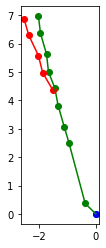

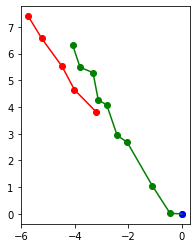

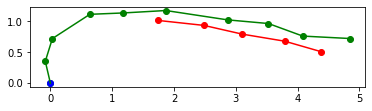

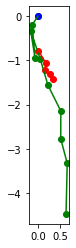

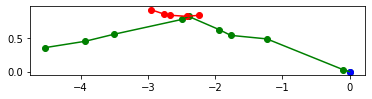

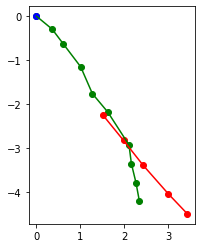

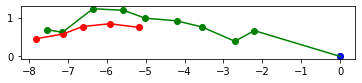

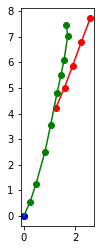

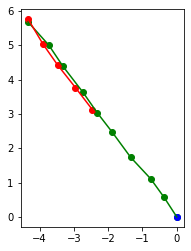

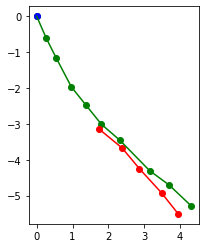

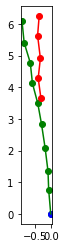

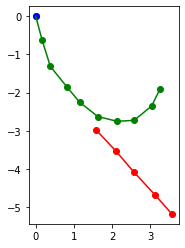

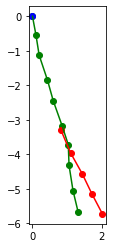

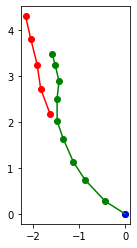

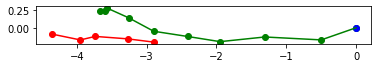

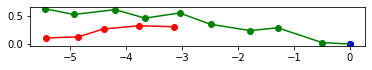

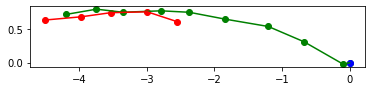

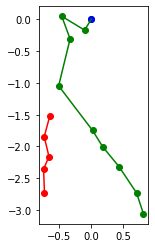

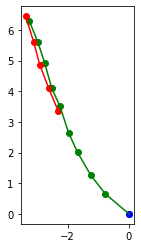

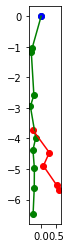

Average FDE:  0.9764549709002771


In [74]:
all_FDE = []
plotting = True
no_of_plotted_trajectories = 20

for idx, agent_id in enumerate(test_agent_ids):

    seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
    seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
    unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
    unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

    pred_x, pred_y = model.predict(np.array([np.column_stack((seen_x, seen_y))]))

    FDE = np.sqrt((pred_x[0][-1] - unseen_x[-1])**2 + (pred_y[0][-1] - unseen_y[-1])**2)
    all_FDE.append(FDE)
    # plot data
    if plotting and idx < no_of_plotted_trajectories:
        plt.axes().set_aspect('equal')

        plt.plot(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')
        plt.scatter(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')

        plt.plot(pred_x[0], pred_y[0], color='r')
        plt.scatter(pred_x[0], pred_y[0], color='r')

        plt.scatter(seen_x[0], seen_y[0], color='b')

        plt.show()

print("Average FDE: ", np.mean(all_FDE))

## Testing different hyperparameters

In [14]:
# NN architecture
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

inp = Input((5,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

out1 = Dense(5, activation='linear')(x)    
out2 = Dense(5, activation='linear')(x)

In [20]:
tf.get_logger().setLevel('ERROR')

learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [1, 4, 8, 16, 32]
loss_functions = ['mean_squared_error', root_mean_squared_error]

all_train_RMSE = []
all_test_RMSE = []

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for loss_function in loss_functions:
            model = Model(inputs=inp, outputs=[out1,out2])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = loss_function)

            model.fit(train[0], [train[1], train[2]], epochs=200, batch_size=32, verbose=0)
            
            trainScore = model.evaluate(train[0], [train[1], train[2]], verbose=0)
            testScore = model.evaluate(test[0], [test[1], test[2]], verbose=0)
            
            if loss_function == 'mean_squared_error':
                all_train_RMSE.append(np.sqrt(trainScore[0]))
                all_test_RMSE.append(np.sqrt(testScore[0]))
                #Wprint("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function))
                #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], np.sqrt(trainScore[0])))
                #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], np.sqrt(testScore[0])))
            else:
                all_train_RMSE.append(trainScore[0])
                all_test_RMSE.append(testScore[0])
                #print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function.__name__))
                #print('Train Score: %.2f RMSE' % (trainScore[0]))
                #print('Test Score: %.2f RMSE' % (testScore[0]))


2022-01-07 12:18:51.209795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:19:43.952301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:19:44.418857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:20:33.749003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:20:34.191168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:21:24.954781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:21:25.433058: I tensorflow/core/grappler/optimizers/cust

2022-01-07 12:42:00.810185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:42:01.335357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:42:51.578456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:42:52.074109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:43:43.253219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:43:43.772148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:44:37.342558: I tensorflow/core/grappler/optimizers/cust

In [55]:
best_learning_rate = None
best_batch_size = None
best_loss_function = None
best_test_rmse = min(all_test_RMSE)
best_test_rmse_idx = all_test_RMSE.index(best_test_rmse)

rmse_idx = 0
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for loss_function in loss_functions:
            
            if rmse_idx == best_test_rmse_idx:
                best_learning_rate = learning_rate
                best_batch_size = batch_size
                if loss_function == 'mean_squared_error':
                    best_loss_function = loss_function
                else:
                    best_loss_function = loss_function.__name__
            
            if loss_function == 'mean_squared_error':
                print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function))
            else:
                print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function.__name__))
            print('Train Score: %.2f RMSE' % (all_train_RMSE[rmse_idx]))
            print('Test Score: %.2f RMSE' % (all_test_RMSE[rmse_idx]))
            print()
            rmse_idx += 1

Learning rate: 0.001, batch size: 1, loss function: mean_squared_error
Train Score: 0.46 RMSE
Test Score: 1.23 RMSE

Learning rate: 0.001, batch size: 1, loss function: root_mean_squared_error
Train Score: 0.65 RMSE
Test Score: 1.68 RMSE

Learning rate: 0.001, batch size: 4, loss function: mean_squared_error
Train Score: 0.45 RMSE
Test Score: 1.24 RMSE

Learning rate: 0.001, batch size: 4, loss function: root_mean_squared_error
Train Score: 0.65 RMSE
Test Score: 1.69 RMSE

Learning rate: 0.001, batch size: 8, loss function: mean_squared_error
Train Score: 0.45 RMSE
Test Score: 1.27 RMSE

Learning rate: 0.001, batch size: 8, loss function: root_mean_squared_error
Train Score: 0.64 RMSE
Test Score: 1.72 RMSE

Learning rate: 0.001, batch size: 16, loss function: mean_squared_error
Train Score: 0.46 RMSE
Test Score: 1.30 RMSE

Learning rate: 0.001, batch size: 16, loss function: root_mean_squared_error
Train Score: 0.63 RMSE
Test Score: 1.70 RMSE

Learning rate: 0.001, batch size: 32, loss

In [56]:
print("Best test RMSE: ", best_test_rmse)
print("Best learning rate: ", best_learning_rate)
print("Best batch size: ", best_batch_size)
print("Best loss function: ", best_loss_function)

Best test RMSE:  1.2300382315113683
Best learning rate:  0.001
Best batch size:  1
Best loss function:  mean_squared_error
